In [4]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

def PILP_algorithm(N, w, r, W, η, n, μ):
    #H = Estimate_Heats(w, r, W, η)
    P = Custom_Initialization(n, w, W)
    #B = Update_Best(P)
    k = Updata_Best(P)
    B = P[k][0]
    f_T = P[k][1]
    f_log = []
    t = 0
    err = 1
    
    #while F(B) < η:
    while f_T < η and err >= 1e-16:
        Q = []
        
        while len(Q) < n:
            ID1, ID2, ID3, ID4 = random.sample(range(n), 4)
            parent1 = tournament_Selection(P[ID1], P[ID2])
            parent2 = tournament_Selection(P[ID3], P[ID4])
            offspring = Custom_Recombination(parent1[0], parent2[0])
            repair1 = Custom_Repair1(offspring)
            #print(repair1)
            repair2 = Custom_Repair2(repair1)
            #print(repair2)
            fitness = F(repair2)
            Q.append((repair2, fitness))
        
        #B = Update_Best(Q)
        k = Updata_Best(Q)
        B = Q[k][0]
        err = abs(f_T - Q[k][1])
        f_T = Q[k][1]
        f_log.append(f_T)
        P = Q
        t += 1
        print(t, f_T, err)
    
    f_T = F(B)
    
    #return H, B, f_T, f_log
    return B, f_T, f_log


def Estimate_Heats(w, r, W, η):
    # Calculate the number of heats needed
    M = sum([r[j]*w[j] for j in range(len(w))])  # Calculate total metal needed
    metal = 0
    i = 0

    while metal <= M:
        metal += η * W
        i += 1

    H = i  # Minimum number of heats needed to melt M

    return H

def Custom_Initialization(n, w, W):
    # Initialize n solutions
    A = int(W / min(w))
    P = []

    for k in range(n):
        x = []
        summation = [0] * N
        '''for j in range(len(w)):
            summation = 0
            for i in range(H):
                x.append([])
                x_ij = random.randint(0, A)
                x[i].append(x_ij)
                summation += x_ij
            
            for i in range(H):
                x_ij = round(r[j] * x[i][j] / summation)
                x[i][j] = x_ij'''
        
        for i in range(H):
            x_j = []
            for j in range(len(w)):
                #x.append([])
                x_ij = random.randint(0, A)
                #x[i].append(x_ij)
                x_j.append(x_ij)
                summation[j] += x_ij
            x.append(x_j)
        #print(x)
            
        for j in range(N):
            for i in range(H):
                x_ij = round(r[j] * x[i][j] / summation[j])
                x[i][j] = x_ij
        
        # Convert the 2D list x to a numpy array
        x = np.array(x)
        #print(x)
        x = Custom_Repair1(x)
        #print(x)
        repaired_x = Custom_Repair2(x)
        #print(x)
        fitness = F(repaired_x)
        
        P.append((repaired_x, fitness))

    return P

def Updata_Best(P):
    # Find the best feasible solution in P
    best_fitness = float('-inf')
    best_solution = None

    for k in range(len(P)):
        solution, fitness = P[k]
        if fitness > best_fitness:
            best_k = k
            best_fitness = fitness
            best_solution = solution

    return best_k
    #return best_solution

def tournament_Selection(x1, x2):
    # Perform tournament selection and return the better solution
    return x1 if x1[1] > x2[1] else x2

def Custom_Recombination(parent1, parent2):
    # Perform custom recombination to create a new solution
    offspring = []
    U_p1_i = [0] * H
    U_p2_i = [0] * H

    for i in range(H):
        U_p1_i[i] = W - sum([w[j] * parent1[i][j] for j in range(N)])  # Remaining crucible space in each heat for parent 1
        U_p2_i[i] = W - sum([w[j] * parent2[i][j] for j in range(N)])  # Remaining crucible space in each heat for parent 2
        #print(U_p1_i)
        #print(U_p2_i)

        if (U_p1_i[i] >= 0 and U_p2_i[i] <= 0) or (U_p1_i[i] >= 0 and U_p2_i[i] > 0 and U_p1_i[i] < U_p2_i[i]) or (U_p1_i[i] < 0 and U_p2_i[i] < 0 and U_p1_i[i] > U_p2_i[i]):
            # If the first parent has better metal utilization
            offspring.append(parent1[i])
        else:
            # Else, child solution inherits assignment from second parent
            offspring.append(parent2[i])

    return offspring

def Custom_Repair1(x):
    # Repair offspring for equality constraint satisfaction
    for j in range(N):
        #U_i = [W[i] - sum([w[j] * x[i][j] for j in range(N)]) for i in range(H)]
        #print(j)

        while sum([x[i][j] for i in range(H)]) != r[j]:
            U_i = [W - sum([w[k] * x[i][k] for k in range(N)]) for i in range(H)]
            #print(sum([x[i][j] for i in range(H)]))
            #U_i1 = sorted(U_i, reverse=False)#minID
            if sum([x[i][j] for i in range(H)]) > r[j]:
                sorted_indices = sorted(range(H), key=lambda i: U_i[i])  # Sorted indices of U_i in ascending order
                m = 1
                minID = sorted_indices[0]
                while x[minID][j] < 1:
                    if m >= H:
                        print("m >= H. Unable to satisfy equality constraints.")
                        break
                    minID = sorted_indices[m]
                    m += 1
                
                x[minID][j] -= 1
            elif sum([x[i][j] for i in range(H)]) < r[j]:
                maxID = max(range(H), key=lambda i: U_i[i])
                x[maxID][j] += 1

    return x

def Custom_Repair2(x):
    # Repair repair1 for inequality constraint satisfaction
    #U_i = W
    #for i in range(H):
    #    U_i[i] = W - sum([w[j] * x[i][j] for j in range(N)])
    U_i = [W - sum([w[j] * x[i][j] for j in range(N)]) for i in range(H)]
    minID = min(range(H), key=lambda i: U_i[i])
    max_attempts = 20000
    attempt = 0

    while U_i[minID] < 0 and attempt < max_attempts:
        objID = random.choice([j for j in range(N) if x[minID][j] > 0])
        x[minID][objID] -= 1
        maxID = max(range(H), key=lambda i: U_i[i])
        x[maxID][objID] += 1

        #for i in range(H):
        #    U_i[i] = W - sum([w[j] * x[i][j] for j in range(N)])
        U_i = [W - sum([w[j] * x[i][j] for j in range(N)]) for i in range(H)]
        #print(U_i)

        minID = min(range(H), key=lambda i: U_i[i])
        attempt += 1

    if attempt >= max_attempts:
        print("Reached maximum attempts. Unable to satisfy inequality constraints.")


    return x

def F(solution):
    # Calculate the objective value of the solution
    x = solution
    R = (1 - η) * (W ** 2)
    #return sum(sum(w[j] * x[i][j] for j in range(N)) / W(i) for i in range(H)) / H - R * (sum((sum(x[i][j] for i in range(H)) - r[j]) ** 2 for j in range(N)) + sum(a ** 2 if (a = sum(w[j] * x[i][j] for j in range(N)) / W[i] - 1)> 0 else 0) for i in range(H))
    #return sum(sum(w[j] * x[i][j] for j in range(N)) / W for i in range(H)) / H - R * (sum((sum(x[i][j] for i in range(H)) - r[j]) ** 2 for j in range(N)) + sum(a ** 2 if (a = sum(w[j] * x[i][j] for j in range(N)) / W - 1) > 0 else 0 for i in range(H)))
    #for i in range(H):
    #    sum1 = sum(w[j] * x[i][j] for j in range(N)) / W
    #term1 = sum1 / H
    term1 = sum(sum(w[j] * solution[i][j] for j in range(N)) / W for i in range(H)) / H
    term2 = sum((sum(x[i][j] for i in range(H)) - r[j]) ** 2 for j in range(N))
    term3 = 0
    for i in range(H):
        a = sum(w[j] * x[i][j] for j in range(N)) / W - 1
        term3 += a ** 2 if a > 0 else 0
    return (term1 - R * (term2 + term3))

starttime = time.time()
#Read data for csv
path = 'E:\山东大学\PILP\Data_2000.CSV'
df = pd.read_csv(path,encoding='gb2312')
df_array = np.array(df)
df_list = df_array.tolist()

# Usage example
N = int(df_list[0][0])
w = list(map(int, df_list[1]))
r = list(map(int, df_list[2]))
W = int(df_list[3][0])
η = df_list[4][0]
n = int(df_list[5][0])
μ = df_list[6][0]

H = Estimate_Heats(w, r, W, η)
print(H)
solution, f_T, f_log = PILP_algorithm(N, w, r, W, η, n, μ)
plt.plot(f_log)
print(H, solution)
endtime = time.time()
print(endtime - starttime)

# Process the obtained solution and objective value as needed


200
Reached maximum attempts. Unable to satisfy inequality constraints.
Reached maximum attempts. Unable to satisfy inequality constraints.
Reached maximum attempts. Unable to satisfy inequality constraints.
Reached maximum attempts. Unable to satisfy inequality constraints.
Reached maximum attempts. Unable to satisfy inequality constraints.
Reached maximum attempts. Unable to satisfy inequality constraints.
Reached maximum attempts. Unable to satisfy inequality constraints.
Reached maximum attempts. Unable to satisfy inequality constraints.
Reached maximum attempts. Unable to satisfy inequality constraints.
Reached maximum attempts. Unable to satisfy inequality constraints.
Reached maximum attempts. Unable to satisfy inequality constraints.
Reached maximum attempts. Unable to satisfy inequality constraints.
Reached maximum attempts. Unable to satisfy inequality constraints.
Reached maximum attempts. Unable to satisfy inequality constraints.
Reached maximum attempts. Unable to satisfy 

KeyboardInterrupt: 

1 -13.630384615384527 0
2 -4.030384615384584 0
3 -0.13038461538460822 0
4 0.019615384615390696 1
5 0.9946153846153847 2
6 -0.055384615384608704 0
7 0.9946153846153847 1
8 0.9946153846153847 3
200
14.682035446166992
7.0495970249176025


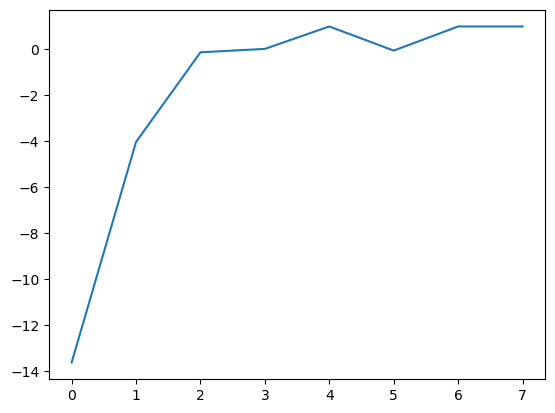

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

def PILP_algorithm(N, w, r, W, η, n, μ):
    #H = Estimate_Heats(w, r, W, η)
    P = Custom_Initialization(n, w, W)
    #B = Update_Best(P)
    k = Updata_Best(P)
    B = P[k][0]
    f_T = P[k][1]
    f_log = []
    t = 0
    err = 1
    
    #while F(B) < η:
    while f_T < η and err >= 1e-16:
        Q = []
        Feasible_solution = 0
        while len(Q) < n:
            ID1, ID2, ID3, ID4 = random.sample(range(n), 4)
            parent1 = tournament_Selection(P[ID1], P[ID2])
            parent2 = tournament_Selection(P[ID3], P[ID4])
            offspring = Custom_Recombination(parent1[0], parent2[0])
            repair1 = Custom_Repair1(offspring)
            repair2 = Custom_Repair2(repair1)
            fitness = F(repair2)
            if fitness > 0:
                Feasible_solution += 1
            Q.append((repair2, fitness))
        
        k = Updata_Best(Q)
        B = Q[k][0]
        err = abs(f_T - Q[k][1])
        f_T = Q[k][1]
        f_log.append(f_T)
        P = Q
        t += 1
        print(t, f_T, Feasible_solution)
    
    f_T = F(B)
    
    return B, f_T, f_log


def Estimate_Heats(w, r, W, η):
    # Calculate the number of heats needed
    M = np.sum(r * w)  # Calculate total metal needed
    metal = 0
    i = 0

    while metal <= M:
        metal += η * W
        i += 1

    H = i  # Minimum number of heats needed to melt M

    return H

def Custom_Initialization(n, w, W):
    # Initialize n solutions
    A = int(W / min(w))
    P = []

    for k in range(n):
        x = []
        summation = [0] * N
        
        for i in range(H):
            x_j = []
            for j in range(len(w)):
                #x.append([])
                x_ij = random.randint(0, A)
                #x[i].append(x_ij)
                x_j.append(x_ij)
                summation[j] += x_ij
            x.append(x_j)
        #print(x)
            
        for j in range(N):
            for i in range(H):
                x_ij = round(r[j] * x[i][j] / summation[j])
                x[i][j] = x_ij
        
        # Convert the 2D list x to a numpy array
        x = np.array(x)
        x = Custom_Repair1(x)
        repaired_x = Custom_Repair2(x)
        fitness = F(repaired_x)
        
        P.append((repaired_x, fitness))

    return P

def Updata_Best(P):
    # Find the best feasible solution in P
    best_fitness = float('-inf')
    best_solution = None

    for k in range(len(P)):
        solution, fitness = P[k]
        if fitness > best_fitness:
            best_k = k
            best_fitness = fitness
            best_solution = solution

    return best_k
    #return best_solution

def tournament_Selection(x1, x2):
    # Perform tournament selection and return the better solution
    return x1 if x1[1] > x2[1] else x2

def Custom_Recombination(parent1, parent2):
    # Perform custom recombination to create a new solution
    offspring = np.empty((0, parent1.shape[1]))  # 创建一个空的二维数组，列数与parent1相同
    
    U_p1_i = W - np.sum(w * parent1, axis = 1)  # Remaining crucible space in each heat for parent 1
    U_p2_i = W - np.sum(w * parent2, axis = 1)  # Remaining crucible space in each heat for parent 2

    for i in range(H):
        if (U_p1_i[i] >= 0 and U_p2_i[i] <= 0) or (U_p1_i[i] >= 0 and U_p2_i[i] > 0 and U_p1_i[i] < U_p2_i[i]) or (U_p1_i[i] < 0 and U_p2_i[i] < 0 and U_p1_i[i] > U_p2_i[i]):
            # If the first parent has better metal utilization
            offspring  = np.vstack((offspring, parent1[i, :]))
        else:
            # Else, child solution inherits assignment from second parent
            offspring  = np.vstack((offspring, parent2[i, :]))

    return offspring

def Custom_Repair1(x):
    # Repair offspring for equality constraint satisfaction
    for j in range(N):
        while np.sum(x[:, j]) != r[j]:
            U_i = W - np.sum(w * x, axis = 1)
            if np.sum(x[:, j]) > r[j]:
                sorted_indices = sorted(range(H), key=lambda i: U_i[i])  # Sorted indices of U_i in ascending order
                m = 1
                minID = sorted_indices[0]
                while x[minID][j] < 1:
                    if m >= H:
                        print("m >= H. Unable to satisfy equality constraints.")
                        break
                    minID = sorted_indices[m]
                    m += 1
                
                x[minID][j] -= 1
            elif np.sum(x[:, j]) < r[j]:
                maxID = U_i.argmax()
                x[maxID][j] += 1

    return x

def Custom_Repair2(x):
    # Repair repair1 for inequality constraint satisfaction
    global Repair2_time
    start_time = time.time()
    U_i = W - np.sum(w * x, axis = 1)
    minID = U_i.argmin()
    max_attempts = H
    attempt = 0

    while U_i[minID] < 0 and attempt <= max_attempts:
        objID = random.choice([j for j in range(N) if x[minID][j] > 0])
        x[minID][objID] -= 1
        maxID = U_i.argmax()
        x[maxID][objID] += 1
        U_i = W - np.sum(w * x, axis = 1)
        minID = U_i.argmin()
        attempt += 1

    #if attempt >= max_attempts:
    #    print("Reached maximum attempts. Unable to satisfy inequality constraints.")
    Repair2_time += time.time() - start_time

    return x

def F(solution):
    # Calculate the objective value of the solution
    x = solution
    term1 = np.sum(np.sum(w * x, axis = 1) / W) / H
    term2 = np.sum((np.sum(x, axis = 0) - r) ** 2)
    term3 = 0
    a = np.sum(w * x, axis = 1) / W - 1
    term3 = np.sum(a[a > 0] ** 2)
    return (term1 - R * (term2 + term3))

starttime = time.time()
#Read data for csv
path = 'E:\山东大学\PILP\Data_2000.CSV'
df = pd.read_csv(path,encoding='gb2312')
df_array = np.array(df)
df_list = df_array.tolist()

# Usage example
N = int(df_list[0][0])
w = df_array[1, :]
r = df_array[2, :]
W = int(df_list[3][0])
η = df_list[4][0]
n = int(df_list[5][0])
μ = df_list[6][0]
R = (1 - η) * (W ** 2)

H = Estimate_Heats(w, r, W, η)
Repair2_time = 0
solution, f_T, f_log = PILP_algorithm(N, w, r, W, η, n, μ)
plt.plot(f_log)
print(H)
endtime = time.time()
print(endtime - starttime)
print(Repair2_time)

# Process the obtained solution and objective value as needed


In [4]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

def PILP_algorithm(N, w, r, W, η, n, μ):
    #H = Estimate_Heats(w, r, W, η)
    P = Custom_Initialization(n, w, W)
    #B = Update_Best(P)
    k = Updata_Best(P)
    B = P[k][0]
    f_T = P[k][1]
    f_log = []
    t = 0
    err = 1
    
    #while F(B) < η:
    while f_T < η and err >= 1e-16:
        Q = []
        Feasible_solution = 0
        while len(Q) < n:
            ID1, ID2, ID3, ID4 = random.sample(range(n), 4)
            parent1 = tournament_Selection(P[ID1], P[ID2])
            parent2 = tournament_Selection(P[ID3], P[ID4])
            offspring = Custom_Recombination(parent1[0], parent2[0])
            offspring = Variation(offspring)
            repair1 = Custom_Repair1(offspring)
            repair2 = Custom_Repair2(repair1)
            fitness = F(repair2)
            if fitness > 0:
                Feasible_solution += 1
            Q.append((repair2, fitness))
        
        k = Updata_Best(Q)
        B = Q[k][0]
        err = abs(f_T - Q[k][1])
        f_T = Q[k][1]
        f_log.append(f_T)
        P = Q
        t += 1
        print(t, f_T, Feasible_solution)
    
    f_T = F(B)
    
    return B, f_T, f_log


def Estimate_Heats(w, r, W, η):
    # Calculate the number of heats needed
    M = np.sum(r * w)  # Calculate total metal needed
    metal = 0
    i = 0

    while metal <= M:
        metal += η * W
        i += 1

    H = i  # Minimum number of heats needed to melt M

    return H

def Custom_Initialization(n, w, W):
    # Initialize n solutions
    A = int(W / min(w))
    P = []

    for k in range(n):
        x = []
        summation = [0] * N
        
        for i in range(H):
            x_j = []
            for j in range(len(w)):
                #x.append([])
                x_ij = random.randint(0, A)
                #x[i].append(x_ij)
                x_j.append(x_ij)
                summation[j] += x_ij
            x.append(x_j)
        #print(x)
            
        for j in range(N):
            for i in range(H):
                x_ij = round(r[j] * x[i][j] / summation[j])
                x[i][j] = x_ij
        
        # Convert the 2D list x to a numpy array
        x = np.array(x)
        x = Custom_Repair1(x)
        repaired_x = Custom_Repair2(x)
        fitness = F(repaired_x)
        
        P.append((repaired_x, fitness))

    return P

def Updata_Best(P):
    # Find the best feasible solution in P
    best_fitness = float('-inf')
    best_solution = None

    for k in range(len(P)):
        solution, fitness = P[k]
        if fitness > best_fitness:
            best_k = k
            best_fitness = fitness
            best_solution = solution

    return best_k
    #return best_solution

def tournament_Selection(x1, x2):
    # Perform tournament selection and return the better solution
    return x1 if x1[1] > x2[1] else x2

def Custom_Recombination(parent1, parent2):
    # Perform custom recombination to create a new solution
    offspring = np.empty((0, parent1.shape[1]))  # 创建一个空的二维数组，列数与parent1相同
    
    U_p1_i = W - np.sum(w * parent1, axis = 1)  # Remaining crucible space in each heat for parent 1
    U_p2_i = W - np.sum(w * parent2, axis = 1)  # Remaining crucible space in each heat for parent 2

    for i in range(H):
        if (U_p1_i[i] >= 0 and U_p2_i[i] <= 0) or (U_p1_i[i] >= 0 and U_p2_i[i] > 0 and U_p1_i[i] < U_p2_i[i]) or (U_p1_i[i] < 0 and U_p2_i[i] < 0 and U_p1_i[i] > U_p2_i[i]):
            # If the first parent has better metal utilization
            offspring  = np.vstack((offspring, parent1[i, :]))
        else:
            # Else, child solution inherits assignment from second parent
            offspring  = np.vstack((offspring, parent2[i, :]))

    return offspring

def Variation(x):
    num = int(alpha * H * N)
    for i in range(num):
        row = random.randint(0, H - 1)
        column = random.randint(0, N - 1)
        variable = random.randint(-2, 2)
        x[row][column] += variable
    np.absolute(x)
    
    
def Custom_Repair1(x):
    # Repair offspring for equality constraint satisfaction
    for j in range(N):
        while np.sum(x[:, j]) != r[j]:
            U_i = W - np.sum(w * x, axis = 1)
            if np.sum(x[:, j]) > r[j]:
                sorted_indices = sorted(range(H), key=lambda i: U_i[i])  # Sorted indices of U_i in ascending order
                m = 1
                minID = sorted_indices[0]
                while x[minID][j] < 1:
                    if m >= H:
                        print("m >= H. Unable to satisfy equality constraints.")
                        break
                    minID = sorted_indices[m]
                    m += 1
                
                x[minID][j] -= 1
            elif np.sum(x[:, j]) < r[j]:
                maxID = U_i.argmax()
                x[maxID][j] += 1

    return x

def Custom_Repair2(x):
    # Repair repair1 for inequality constraint satisfaction
    global Repair2_time
    start_time = time.time()
    U_i = W - np.sum(w * x, axis = 1)
    minID = U_i.argmin()
    max_attempts = H
    attempt = 0

    while U_i[minID] < 0 and attempt <= max_attempts:
        objID = random.choice([j for j in range(N) if x[minID][j] > 0])
        x[minID][objID] -= 1
        maxID = U_i.argmax()
        x[maxID][objID] += 1
        U_i = W - np.sum(w * x, axis = 1)
        minID = U_i.argmin()
        attempt += 1

    #if attempt >= max_attempts:
    #    print("Reached maximum attempts. Unable to satisfy inequality constraints.")
    Repair2_time += time.time() - start_time

    return x

def F(solution):
    # Calculate the objective value of the solution
    x = solution
    term1 = np.sum(np.sum(w * x, axis = 1) / W) / H
    term2 = np.sum((np.sum(x, axis = 0) - r) ** 2)
    term3 = 0
    a = np.sum(w * x, axis = 1) / W - 1
    term3 = np.sum(a[a > 0] ** 2)
    return (term1 - R * (term2 + term3))

starttime = time.time()
#Read data for csv
path = 'E:\山东大学\PILP\Data_2000.CSV'
df = pd.read_csv(path,encoding='gb2312')
df_array = np.array(df)
df_list = df_array.tolist()

# Usage example
N = int(df_list[0][0])
w = df_array[1, :]
r = df_array[2, :]
W = int(df_list[3][0])
η = df_list[4][0]
n = int(df_list[5][0])
μ = df_list[6][0]
R = (1 - η) * (W ** 2)
alpha = 0.05

H = Estimate_Heats(w, r, W, η)
Repair2_time = 0
solution, f_T, f_log = PILP_algorithm(N, w, r, W, η, n, μ)
plt.plot(f_log)
print(H)
endtime = time.time()
print(endtime - starttime)
print(Repair2_time)

# Process the obtained solution and objective value as needed


TypeError: 'NoneType' object is not subscriptable